## Import the necessary software libraries:

In [1]:
# !pip install 'gym[box2d]'
# !apt-get install python-opengl -y
# !apt install xvfb -y
# !pip install pyvirtualdisplay
# !pip install https://github.com/pyglet/pyglet/archive/pyglet-1.5-maintenance.zip
# !apt-get install ffmpeg -y
# !pip install torch==1.6

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0,size=(600,600))
display.start()

In [3]:
import os
import torch
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW

from utils import test_policy_network, seed_everything, plot_stats, plot_action_probs
from parallel_env import ParallelEnv, ParallelWrapper

## Create and preprocess the environment

### Create the environment

In [4]:
env = gym.make('CartPole-v0')

In [5]:
dims = env.observation_space.shape[0]
actions = env.action_space.n
dims, actions

(4, 2)

In [6]:
env.reset()

array([-0.00530791,  0.00248644,  0.0194639 ,  0.00903229])

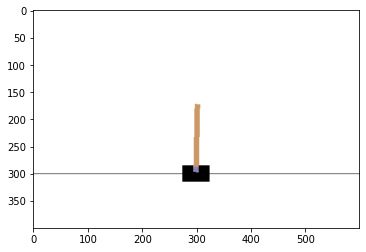

In [7]:
plt.imshow(env.render(mode="rgb_array"))

### Parallelize the environment

In [8]:
num_envs = os.cpu_count()
num_envs

2

In [9]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    seed_everything(env, seed=seed)
    return env

In [10]:
env_fns = [lambda : create_env('CartPole-v0', rank) for rank in range(num_envs)]
parallel_env = ParallelEnv(env_fns)

In [11]:
parallel_env.reset()

array([[ 0.03073904,  0.00145001, -0.03088818, -0.03131252],
       [ 0.03073904,  0.00145001, -0.03088818, -0.03131252]],
      dtype=float32)

### Prepare the environment to work with PyTorch

In [12]:
class PreprocessEnv(ParallelWrapper):

    def __init__(self, parallel_env):
        ParallelWrapper.__init__(self,parallel_env)

    # reset
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()

    # step_async
    def step_async(self, actions):
        """
        [[3],[2],[1]] -> [3,2,1]
        """
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)

    # step_wait
    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [13]:
parallel_env = PreprocessEnv(parallel_env)

In [14]:
state = parallel_env.reset()
_, reward, done, _ = parallel_env.step(torch.zeros(num_envs,1, dtype=torch.int32))

In [15]:
state

tensor([[ 0.0273, -0.0448, -0.0430,  0.0015],
        [ 0.0273, -0.0448, -0.0430,  0.0015]])

In [16]:
reward

tensor([[1.],
        [1.]])

In [17]:
done

tensor([[False],
        [False]])

### Create the policy $\pi(s)$

In [18]:
policy = nn.Sequential(
    nn.Linear(dims, 128), 
    nn.ReLU(),
    nn.Linear(128, 64), 
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1)
)

### Plot action probabilities

In [19]:
neutral_state = torch.zeros(4)
left_danger = torch.tensor([-2.3, 0., 0., 0.])
right_danger = torch.tensor([2.3, 0., 0., 0.])

#### Plot a neutral environment

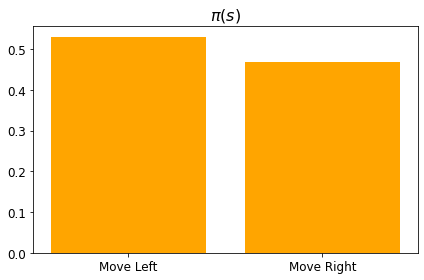

In [20]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far left

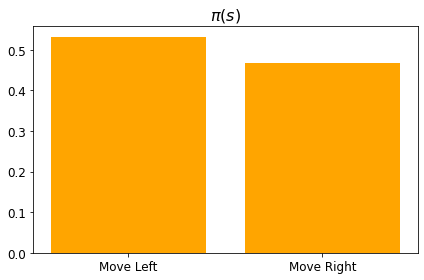

In [21]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far right

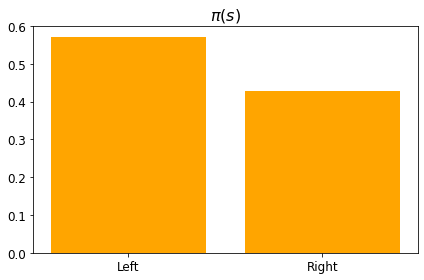

In [22]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

## Implement the algorithm

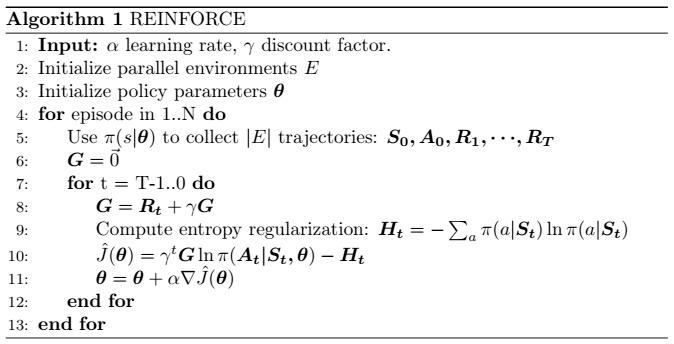

In [23]:
def reinforce(policy, episodes, alpha=1e-4, gamma=0.99):
    
    optim = AdamW(policy.parameters(),lr = alpha)
    stats = {'MSE Loss':[],'Returns':[]}

    for episode in tqdm(range(1, episodes+1)):

        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype = torch.bool)
        transitions = []
        ep_return = torch.zeros((num_envs, 1))

        while not done_b.all():

            # [0.1. 0.3, 0.5, 0.1] -> 2
            action = policy(state).multinomial(1).detach()

            next_state, reward, done, _ = parallel_env.step(action)
            transitions.append([state, action, ~done_b * reward])

            ep_return += reward
            done_b |= done
            state = next_state

        G = torch.zeros((num_envs,1))

        for t, (state_t, action_t, reward_t) in reversed(list(enumerate(transitions))):
            G = reward_t + gamma * G
            probs_t = policy(state_t)
            log_probs_t = torch.log(probs_t + 1e-6)
            action_log_prob_t = log_probs_t.gather(1, action_t)

            entropy_t = - torch.sum(probs_t * log_probs_t, dim=-1, keepdim=True)
            gamma_t = gamma ** t
            pg_loss_t = - gamma_t * action_log_prob_t * G
            total_loss_t = (pg_loss_t - 0.01 * entropy_t).mean()
            
            policy.zero_grad()
            total_loss_t.backward()
            optim.step()
        
        stats['MSE Loss'].append(total_loss_t.item())
        stats['Returns'].append(ep_return.mean().item())

    return stats

In [24]:
parallel_env.reset()

tensor([[ 0.0189, -0.0040,  0.0402,  0.0275],
        [ 0.0189, -0.0040,  0.0402,  0.0275]])

In [25]:
stats = reinforce(policy, 1000, alpha=1e-4, gamma=0.99)

100%|██████████| 1000/1000 [06:43<00:00,  2.48it/s]


## Show results

### Show execution stats

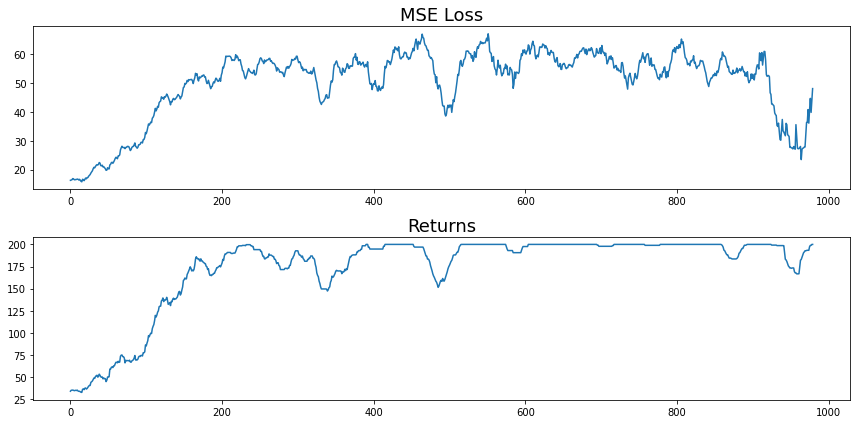

In [31]:
plot_stats(stats)

### Plot action probabilities

#### Plot a neutral environment

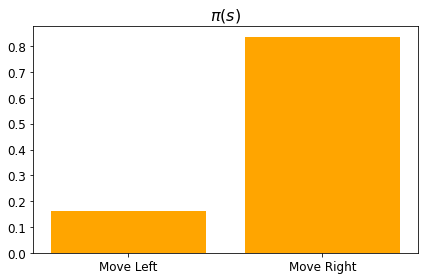

In [32]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far left

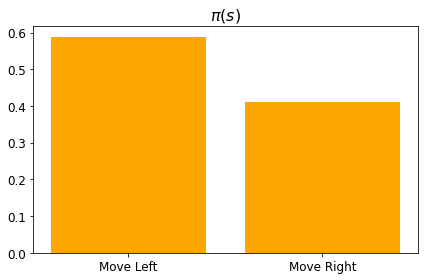

In [33]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far right

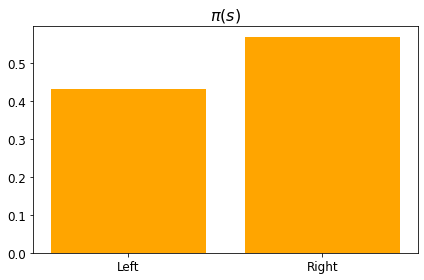

In [34]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

### Test the resulting agent

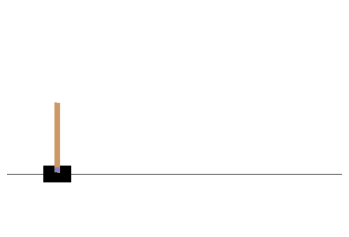

In [35]:
test_policy_network(env, policy, episodes=5)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)